In [31]:
import matplotlib.pyplot as plt
import numpy as np
from data_tools.query import DBClient 
from data_tools.collections import TimeSeries
import datetime

from dotenv import load_dotenv

In [32]:
client = DBClient(
    influxdb_token="s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==",
    influxdb_org="8a0b66d77a331e96")

start_fsgp = datetime.datetime.fromisoformat("2024-07-16T14:00:00Z")
stop_fsgp = datetime.datetime.fromisoformat("2024-07-17T01:00:00Z")

pack_voltage_fsgp = client.query_time_series(start=start_fsgp, stop=stop_fsgp, field="TotalPackVoltage", bucket="CAN_log", granularity=0.1, units="V", car="Brightside")
pack_current_fsgp = client.query_time_series(start=start_fsgp, stop=stop_fsgp, field="PackCurrent", bucket="CAN_log", granularity=0.1, units="A", car="Brightside")

pack_voltage_fsgp, pack_current_fsgp =TimeSeries.align(pack_voltage_fsgp, pack_current_fsgp)

In [33]:
R_0_data = [0.17953765302439662, 0.15580951404728172, 0.14176929930784543, 0.11043950958574644, 0.13930042505446938, 0.1552885289394773, 0.044070982259896085, 0.2208806896239539, 0.15116267852908616, 0.6553961767519164]
R_P_data = [0.04153180244191346, 0.10674683402208612, 0.061085424180509884, 0.0781407642082238, 0.05537901113775878, 0.09732054673529467, 0.07662520885708152, 0.09799857401036915, 0.42622740149661487, 0.2718418915736874]
C_P_data = [14824.398495212006, 1587.5971318119796, 341.1064063616048, 1243.182413110655, 619.5791066439332, 2252.7885790042164, 954.5884882581622, 515.7219779825028, 431.10892633451135, 195.14394897766627]
Uoc_data = [131.88002282453857, 129.4574321366064, 125.5750277614186, 121.99586066440303, 118.69893412178982, 115.71854177322408, 111.99025635444923, 108.29354777060836, 98.23397960300946, 95.24125831782388]
Q_estimated = Q_total = 137541.31995522053
SOC_data = [1.0000113624123392, 0.8815263722745977, 0.7671918526292492, 0.6206071038045673, 0.4911613638651783, 0.3606311083423134, 0.23687514228021178, 0.12073345089992571, 0.01456057818183809, 0.0070648691224265425]

In [58]:
from physics.models.battery import BatteryModelConfig, BatteryModel

battery_config = BatteryModelConfig(
    R_0_data=R_0_data,  # Optimized R_0_data
    R_P_data=R_P_data,        # Optimized R_P
    C_P_data=C_P_data,        # Optimized C_P
    Q_total=Q_total * 1.1,
    SOC_data=SOC_data,     # Hardcoded SOC data
    Uoc_data=Uoc_data,# Optimized Uoc_data
    max_current_capacity=500,
    max_energy_capacity=42.9
)
bm = BatteryModel(battery_config, 1.04)

/var/folders/26/b439y_h53ls_5yw6crm1x55r0000gn/T/ipykernel_89541/2864558815.py:5: DeprecationWarning: Please use TimeSeries.period instead of TimeSeries.granularity
  discharged_capacity = np.cumsum(pack_current_fsgp * pack_current_fsgp.granularity)


184681.13511883566


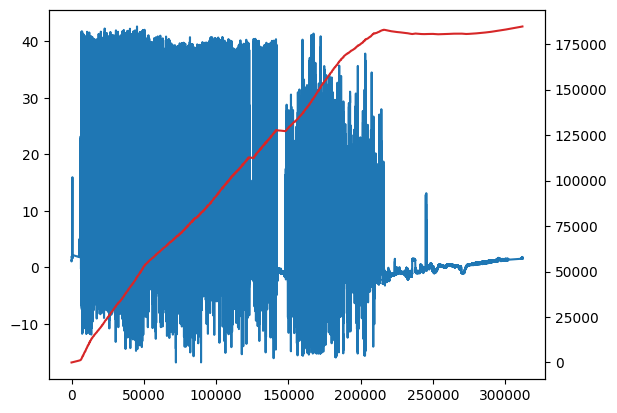

In [60]:
fig, ax = plt.subplots()

ax.plot(pack_current_fsgp, label="Current")
ax2 = ax.twinx()
discharged_capacity = np.cumsum(pack_current_fsgp * pack_current_fsgp.granularity)
ax2.plot(discharged_capacity, label="Discharged Capacity", color="tab:red")
print(max(discharged_capacity))
plt.show()

In [61]:
print(max(discharged_capacity) / Q_estimated)

1.342732025393987


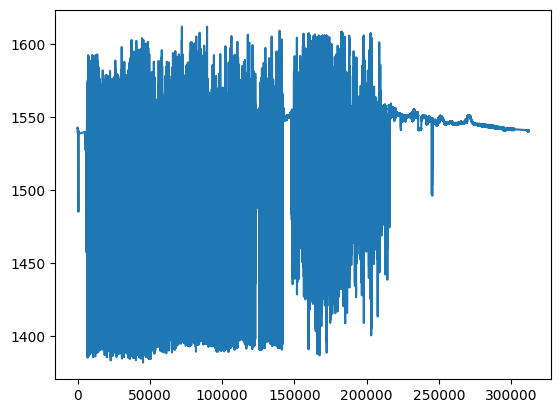

In [62]:
current_error = np.polyval([-0.00388, 1547], pack_current_fsgp * 1000.0)
plt.plot(current_error)
plt.show()

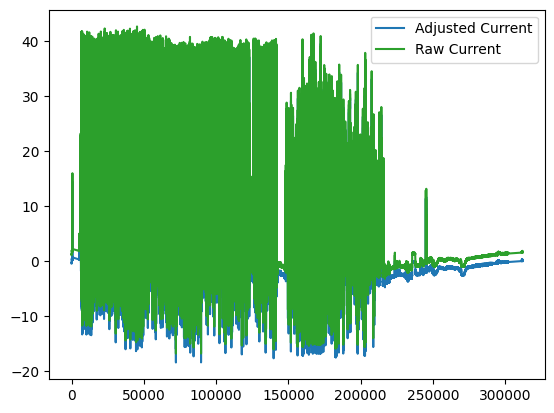

In [63]:
pack_current_fsgp_adjusted = pack_current_fsgp - (current_error / 1000)

fig, ax = plt.subplots()
ax.plot(pack_current_fsgp_adjusted, label="Adjusted Current", color="tab:blue")
ax.plot(pack_current_fsgp, label="Raw Current", color="tab:green")

plt.legend()
plt.show()

/var/folders/26/b439y_h53ls_5yw6crm1x55r0000gn/T/ipykernel_89541/758059029.py:5: DeprecationWarning: Please use TimeSeries.period instead of TimeSeries.granularity
  discharged_capacity_adjusted = np.cumsum(pack_current_fsgp_adjusted * pack_current_fsgp_adjusted.granularity)


150208.41706103936


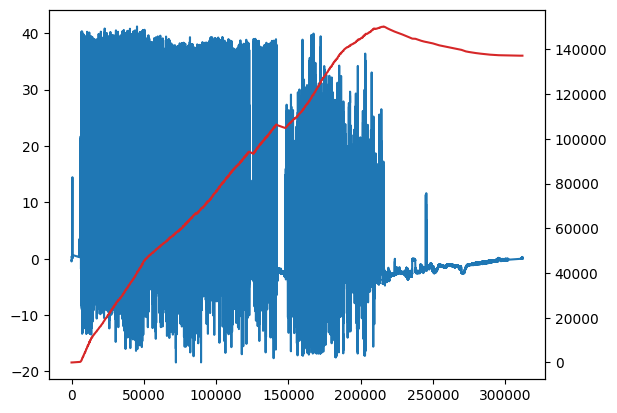

In [64]:
fig, ax = plt.subplots()

ax.plot(pack_current_fsgp_adjusted, label="Current")
ax2 = ax.twinx()
discharged_capacity_adjusted = np.cumsum(pack_current_fsgp_adjusted * pack_current_fsgp_adjusted.granularity)
ax2.plot(discharged_capacity_adjusted, label="Discharged Capacity", color="tab:red")
print(max(discharged_capacity_adjusted))
plt.show()

In [65]:
# Run Battery Model
soc_array, U_predicted = bm.update_array_current(-pack_current_fsgp_adjusted, pack_current_fsgp_adjusted.granularity, rust=True)

/var/folders/26/b439y_h53ls_5yw6crm1x55r0000gn/T/ipykernel_89541/2369751374.py:2: DeprecationWarning: Please use TimeSeries.period instead of TimeSeries.granularity
  soc_array, U_predicted = bm.update_array_current(-pack_current_fsgp_adjusted, pack_current_fsgp_adjusted.granularity, rust=True)


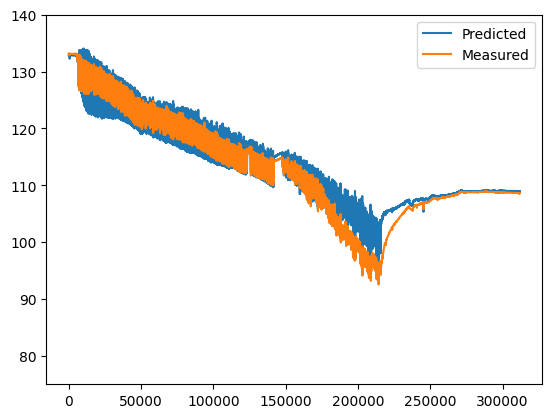

In [66]:
fig, ax = plt.subplots()

ax.plot(U_predicted, label="Predicted")
ax.plot(pack_voltage_fsgp, label="Measured")
ax.set_ylim(75, 140)

plt.legend()
plt.show()

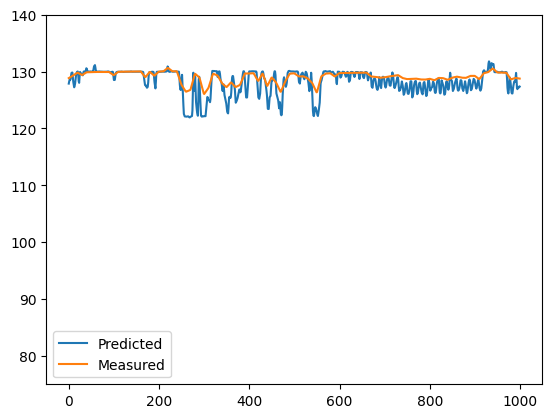

In [67]:
fig, ax = plt.subplots()

window = slice(20000, 21000, 1)

ax.plot(U_predicted[window], label="Predicted")
ax.plot(pack_voltage_fsgp[window], label="Measured")
ax.set_ylim(75, 140)

plt.legend()
plt.show()

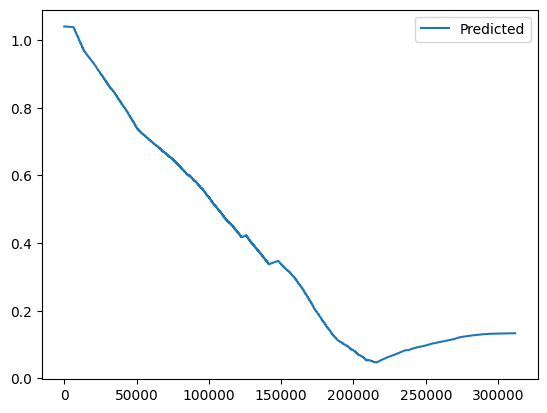

In [68]:
fig, ax = plt.subplots()

ax.plot(soc_array, label="Predicted")
# ax.plot(pack_voltage_fsgp, label="Measured")
# ax.set_ylim(, 140)

plt.legend()
plt.show()


In [248]:
import numpy as np
from scipy import optimize
from filterpy.kalman import ExtendedKalmanFilter as EKF
from physics.models.battery.battery_config import BatteryModelConfig


class EKF_SOC:
    def get_SOC(self):
        """
        Return the current state of charge of the battery.

        :return: The current state of charge.
        :rtype: float
        """
        return self.SOC

    def get_Uc(self):
        """
        Return the polarization voltage of the battery.

        :return: The current polarization voltage.
        :rtype: float
        """
        return self.Uc

    def get_predicted_Ut(self):
        """
        Return the predicted terminal voltage for the last prediction step.

        :return: The predicted terminal voltage.
        :rtype: float
        """
        return self.predicted_measurement

    def update_filter(self, measured_Ut, I):
        """
        Update the filter based on a new measurement and the predicted state.
        This function should be called after `predict_state` in a typical predict-update workflow.

        :param float measured_Ut: The actual voltage across the terminals of the battery.
        :param float I: The current being sourced by the battery.
        """
        alpha = 0.9
        self._filtered_I = alpha * self._filtered_I + (1 - alpha) * I
        
        self.ekf.update(z=measured_Ut, HJacobian=self._measurement_jacobian, Hx=self._measurement_function)

        self.SOC, self.Uc = self.ekf.x
        self.SOC = np.clip(self.SOC, 0.0, 1.1)
        # print(f"Kalman gain: {self.ekf.K}")
        # Uoc = self.U_oc(self.SOC)
        # R0 = self.R_0(self.SOC)
        # self.predicted_measurement = Uoc - self.Uc - R0 * I

    def predict_state(self, I, time_step):
        """
        Predict the next evolution of the state vector (SOC, Uc).
        This function should be called before updating the filter in a typical predict-update workflow.

        :param float I: The current being sourced by the battery. Positive indicates current being drawn.
        :param float time_step: Time elapsed between this prediction and the last updated state of the filter (seconds).
        """
        # check_current(I)
        # Control matrix B (for input current I_k)
        self.ekf.B = np.array([-time_step / self.Q_total, self.R_P(self.SOC) * (1 - np.exp(-time_step / self.tau(self.SOC)))])
        self.ekf.F = self._state_jacobian(time_step)
        
        #     # 🔧 Incorporate uncertainty in current measurement into Q
        # I_noise_std = 0.5  # adjust based on sensor datasheet or empirical tests
        # dq = (time_step / self.Q_total) * I_noise_std
        # duc = self.R_P(self.SOC) * (1 - np.exp(-time_step / self.tau(self.SOC))) * I_noise_std
        # # if I > 5:
        # #     print(f"dq: {dq * 1e2}, duc: {duc * 1e4}, I: {I}")
        # 
        # self.ekf.Q = np.diag([
        #     1e-1 * 0.1,  # add floor to maintain numerical stability
        #     1e3
        # ])
        
        self.ekf.predict(u=I)
        self.SOC, self.Uc = self.ekf.x

        # print(f'ekf prediction: {self.ekf.x_prior}')

    def predict_then_update(self, measured_Ut, I, time_step):
        """
        Predict the next evolution of the state vector (SOC, Uc), then update the filter
        based on this prediction and a measurement. Abstracts the full predict-update workflow of the EKF.

        :param float measured_Ut: The actual voltage across the terminals of the battery.
        :param float I: The current being sourced by the battery. Positive indicates current being drawn.
        :param float time_step: Time elapsed between this prediction and the last updated state of the filter (seconds).
        """
        # check_current(I)
        # check_Terminal_V(measured_Ut)

        self.predict_state(I, time_step)
        # print(f'predicted: {self.ekf.x_prior}')

        self.update_filter(measured_Ut, I)
        # print(f'SOC: {self.ekf.x[0]}, Uc: {self.ekf.x[1]}')

    def _state_jacobian(self, time_step):
        """
        Return the state Jacobian matrix for the current time step.

        :param float time_step: Time elapsed between this prediction and the last updated state of the filter (seconds).
        :return: The state Jacobian matrix.
        :rtype: np.ndarray
        """
        return np.array([[1, 0], [0, np.exp(-time_step / self.tau(self.SOC))]])

    def _measurement_jacobian(self, x):
        """
        Return the measurement Jacobian matrix for the current state vector.

        :param list[float, float] x: The state vector [SOC, Uc].
        :return: The measurement Jacobian matrix.
        :rtype: np.ndarray
        """
        SOC = x[0]
        dUoc_dSOC = self.Uoc_derivative(SOC)
        dR0_dSOC = self.R_0_derivative(SOC)
        return np.array([[dUoc_dSOC - dR0_dSOC * self._filtered_I, -1]])

    def _measurement_function(self, x):
        """
        Return the measurement function relating terminal voltage to SOC and polarization voltage.

        :param list[float, float] x: The state vector [SOC, Uc].
        :param float I: The current being sourced by the battery.
        :return: The predicted terminal voltage.
        :rtype: float
        """
        SOC, Uc = x
        Uoc = self.U_oc(SOC)
        R0 = self.R_0(SOC)
        self.predicted_measurement = Uoc - Uc - R0 * self._filtered_I
        return self.predicted_measurement

    def __init__(self, battery_config: BatteryModelConfig, initial_SOC=1, initial_Uc=0):
        """
        EKF_SOC represents the Kalman filter used for predicting state of charge.

        :param BatteryModelConfig battery_config: Contains the HPPC parameters of the battery model.
        :param float initial_SOC: Initial state of charge of the battery (ranges from 0 to 1 inclusive, default is 1).
        :param float initial_Uc: Initial polarization voltage of the battery in volts (default is 0).
        """
        # Initial state
        self.SOC = initial_SOC
        self.Uc = initial_Uc  # Polarization Voltage

        # Load Config data
        self.Q_total = battery_config.Q_total
        SOC_data = battery_config.SOC_data
        Uoc_data = battery_config.Uoc_data
        R_0_data = battery_config.R_0_data
        R_P_data = battery_config.R_P_data
        C_P_data = battery_config.C_P_data

        def quintic_polynomial(x, x0, x1, x2, x3, x4, x5, x6, x7):
            return np.polyval([x0, x1, x2, x3, x4, x5, x6, x7], x)

        U_oc_coefficients, _ = optimize.curve_fit(quintic_polynomial, SOC_data, Uoc_data)
        R_0_coefficients, _ = optimize.curve_fit(quintic_polynomial, SOC_data, R_0_data)
        R_P_coefficients, _ = optimize.curve_fit(quintic_polynomial, SOC_data, R_P_data)
        C_P_coefficients, _ = optimize.curve_fit(quintic_polynomial, SOC_data, C_P_data)
        self.U_oc = lambda soc: np.polyval(U_oc_coefficients, soc)  # Open-circuit voltage as a function of SOC
        self.R_0 = lambda soc: np.polyval(R_0_coefficients, soc)  # Resistance as a function of SOC
        self.R_P = lambda soc: np.polyval(R_P_coefficients, soc)  # Resistance as a function of SOC
        self.C_P = lambda soc: np.polyval(C_P_coefficients, soc)  # Resistance as a function of SOC
        self.Uoc_derivative = lambda soc: np.polyval(np.polyder(U_oc_coefficients), np.minimum(1.0, soc))  # Derivative of Uoc wrt SOC
        self.R_0_derivative = lambda soc: np.polyval(np.polyder(R_0_coefficients), np.minimum(1.0, soc))

        self.tau = lambda soc: self.R_P(soc) * self.C_P(soc)

        # initializing the ekf object
        self.ekf = EKF(dim_x=2, dim_z=1)
        self.ekf.x = np.array([self.SOC, self.Uc])
        self.ekf.Q = np.diag([
            1e-9 * 0.1,  # add floor to maintain numerical stability
            1e-4 * 0.1
        ])
        self.ekf.P = np.diag(
            [1e-2 * 0.5, 
             1e-1]
        )
        self.ekf.R = np.eye(1) * 1e1 * 0.5

        # For logs
        self._filtered_I = 0
        self.predicted_measurement = 0



In [249]:
ekf_soc = EKF_SOC(battery_config, initial_SOC=1.04, initial_Uc=0.0)

SOC_array = np.zeros(len(pack_voltage_fsgp))
Ut_array = np.zeros(len(pack_voltage_fsgp))
current_array = np.zeros(len(pack_voltage_fsgp))
polarization_voltage_array = np.zeros(len(pack_voltage_fsgp))
predicted_Ut_array = np.zeros(len(pack_voltage_fsgp))
predicted_Uc_array = np.zeros(len(pack_voltage_fsgp))
predicted_Uoc_array = np.zeros(len(pack_voltage_fsgp))

for i in range(int(len(pack_voltage_fsgp))):
# for i in range(20000):
    # Calculate time difference between current and previous measurements
    time_difference = pack_current_fsgp_adjusted.period
    
    Ut = pack_voltage_fsgp[i]
    I = pack_current_fsgp_adjusted[i]
    
    ekf_soc.predict_then_update(Ut, I, time_difference)

    SOC_array[i] = ekf_soc.get_SOC()
    Ut_array[i] = Ut
    current_array[i] = I
    polarization_voltage_array[i] = ekf_soc.get_Uc()
    predicted_Ut_array[i] = ekf_soc.get_predicted_Ut()
    predicted_Uc_array[i] = ekf_soc.get_Uc()
    predicted_Uoc_array[i] = ekf_soc.U_oc(ekf_soc.SOC)


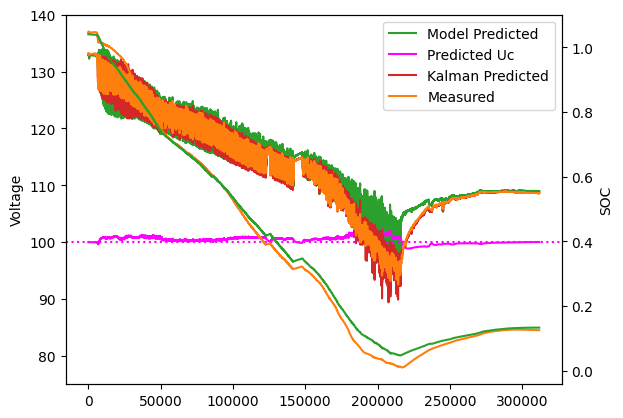

In [250]:
fig, ax = plt.subplots()

# window = slice(0, 20000, 1)
window = slice(0, 311821, 1)

ax.plot(U_predicted[window], label="Model Predicted", color="tab:green")
ax.plot(predicted_Uc_array[window] + 100, label="Predicted Uc", color="magenta")
ax.axhline(y=100, linestyle='dotted', color="magenta")
# ax.plot(predicted_Uoc_array[window], label="Predicted OCV", color="tab:cyan")
ax.plot(predicted_Ut_array[window], label="Kalman Predicted", color="tab:red")
ax.plot(pack_voltage_fsgp[window], label="Measured", color="tab:orange")
ax.set_ylim(75, 140)
ax.set_ylabel("Voltage")
plt.legend()

ax2 = ax.twinx()
ax2.plot(SOC_array[window], color="tab:orange")
ax2.plot(soc_array[window], color="tab:green")
ax2.set_ylabel("SOC")

plt.show()

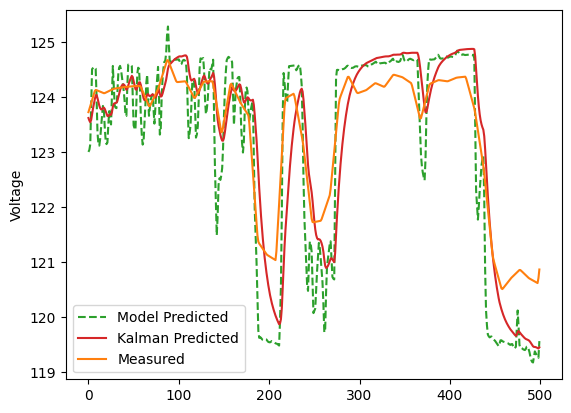

In [255]:
fig, ax = plt.subplots()

# window = slice(0, 20000, 1)
window = slice(50000, 50500, 1)

ax.plot(U_predicted[window], label="Model Predicted", color="tab:green", linestyle="dashed")
ax.plot(predicted_Ut_array[window], label="Kalman Predicted", color="tab:red")
ax.plot(pack_voltage_fsgp[window], label="Measured", color="tab:orange")
# ax.set_ylim(75, 140)
ax.set_ylabel("Voltage")
plt.legend()

plt.show()

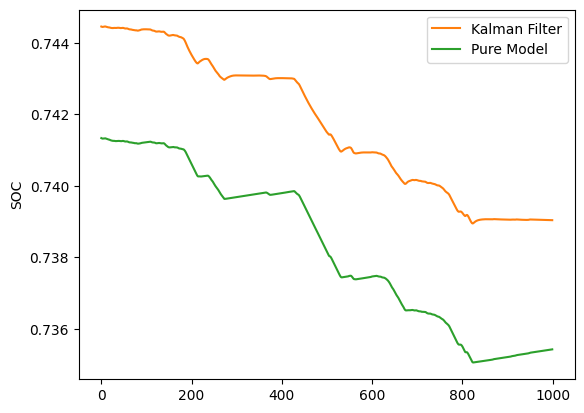

In [256]:
fig, ax = plt.subplots()

# window = slice(0, 20000, 1)
window = slice(50000, 51000, 1)

ax.plot(SOC_array[window], color="tab:orange", label="Kalman Filter")
ax.plot(soc_array[window], color="tab:green", label="Pure Model")
ax.set_ylabel("SOC")
plt.legend()

plt.show()

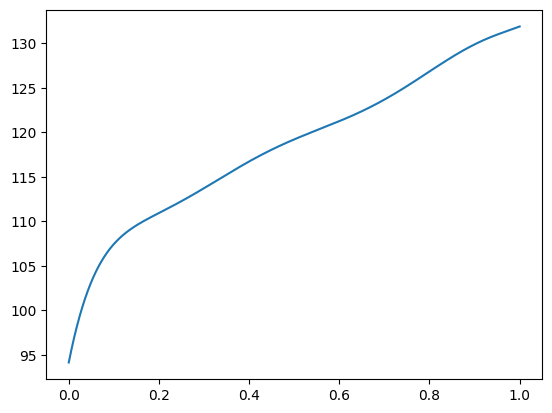

In [145]:
Uocv_ekf = lambda _soc: ekf_soc.U_oc(_soc)

soc = np.linspace(0, 1.0, 1000)
plt.plot(soc, Uocv_ekf(soc))

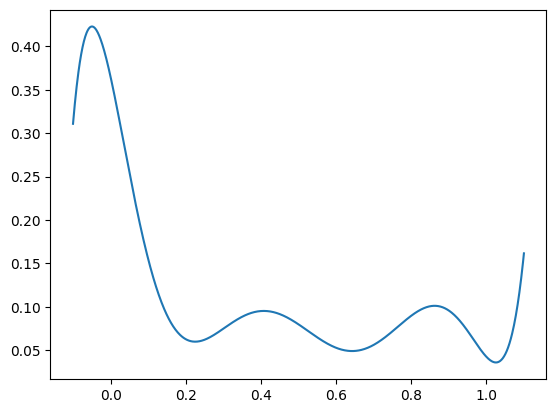

In [146]:
plt.close()
R_P_ekf = lambda _soc: ekf_soc.R_P(_soc)

soc = np.linspace(-0.1, 1.1, 1000)
plt.plot(soc, R_P_ekf(soc))

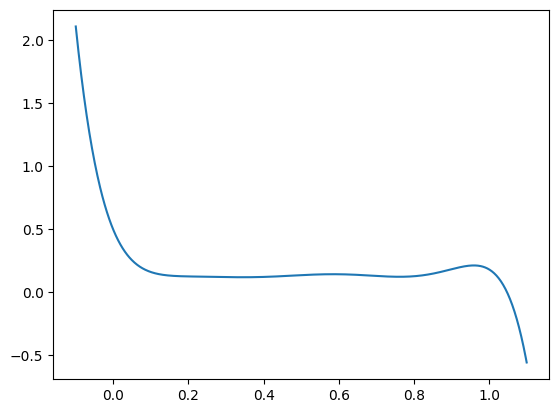

In [147]:
plt.close()
R_0_ekf = lambda _soc: ekf_soc.R_0(_soc)

soc = np.linspace(-0.1, 1.1, 1000)
plt.plot(soc, R_0_ekf(soc))